In [2]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from scipy import ndimage

%matplotlib inline

In [3]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!rm -f data
!ln -s '/content/drive/My Drive/proj2_data' data

#some utility

In [5]:
def collate_fn1(batch):
    return tuple(zip(*batch))

def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type=='turbulence':
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )

    for i in range(len(gt_box)):
      draw_box(gt_box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

# define dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])

    def __getitem__(self, index):
      path, box, turb = self.imgs[index]
      im = (np.load(path))/292*255
      im=np.transpose(im,(1, 2, 0))
      im=np.uint8(im)
      boxes = np.array(box, dtype='float32')
      seed = np.random.randint(2147483647)
      random.seed(seed)
      torch.manual_seed(seed)
      PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
      im = self.transform(PIL)*255


      #return im,target
      return im, boxes, turb

    def __len__(self):
        return len(self.imgs)

In [7]:
#dataloader
train=MyDataset(datatype='train', transform=None)
test=MyDataset(datatype='test', transform=None)
val=MyDataset(datatype='val', transform=None)
datasets={'train':train,'test':test,'val':val}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2,collate_fn=collate_fn1,pin_memory=True) for k, v in datasets.items()}

#test

[[298. 315. 833. 443.]
 [ 83. 379. 315. 463.]
 [ 59. 546. 267. 638.]
 [519. 148. 682. 210.]
 [392. 134. 616. 199.]
 [ 54. 382. 346. 545.]
 [ 24. 239. 130. 295.]
 [475. 515. 585. 591.]]


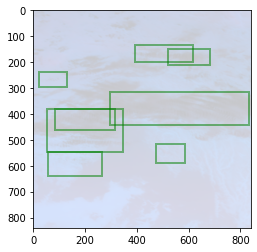

In [8]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]

inp = im.numpy().transpose((1, 2, 0))/255
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
#inp = std * inp + mean
imshow(inp, box,turb)
print(box)

In [9]:
def extractImgbyRoI(img, Coords):
  (x_min, y_min, x_max, y_max) = Coords[0]
  result = img[:, y_min:y_max, x_min:x_max]
  for i in range(1, len(Coords)):
    (x_min, y_min, x_max, y_max) = Coords[i]
    result = np.concatenate((result, img[:, y_min:y_max, x_min:x_max]), axis=2)
  return np.array(result)

In [10]:
def myImgShow(img):
  img = img.transpose((1, 2, 0))/255
  #img = img.numpy().transpose((1, 2, 0))/255
  plt.imshow(img)

In [11]:
def constructNeighbourGrid():
  size = 10
  neighbourGrid = []
 
  for i in range(size):
    for j in range(size):
      background = np.zeros((10, 10))
      #background[i][j] = 1
      # Dilation
      if i-1 >= 0: background[i-1][j] = 1
      if i+1 < size: background[i+1][j] = 1
      if j-1 >= 0: background[i][j-1] = 1
      if j+1 < size: background[i][j+1] = 1

      background = background.flatten()
      neighbourGrid.append(background == 1)

  return np.array(neighbourGrid)

In [12]:
def initCoord(img, size):
  _, h, w = img.shape
  sub_h, sub_w = math.floor(h/size), math.floor(w/size)
  RoIs = np.array([[[j*sub_w, i*sub_h, (j+1)*sub_w-1, (i+1)*sub_h-1] for j in range(size)] for i in range(size)])
  RoIs = RoIs.reshape(size*size, 4)
  return RoIs

In [13]:
def initRegions(size):
  return set([(i) for i in range(size)])

In [14]:
def regionsToCoord(Coords, regions):
  regions_list = tuple2list(regions)
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res

In [15]:
def regionsToCoord_test(Coords, regions):
  print(regions)
  regions_list = tuple2list(regions)
  print(regions_list[0])
  print(Coords[regions_list[0]].reshape(1, 4))
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res

In [16]:
def getHist(img):
  D, _, _ = img.shape
  histogram = []
  for channel_idx in range(D):
    h, _ = np.histogram(img[channel_idx, :, :], bins=25)
    histogram = histogram + list(h)
  histogram = np.array(histogram/np.linalg.norm(histogram, 1))
  return histogram

In [17]:
def sim(region1, region2):
  histogram1 = getHist(region1)
  histogram2 = getHist(region2)

  sim = np.vstack((histogram1, histogram2))
  sim = np.amin(sim, 0)
  sim = sim.sum()

  return sim

In [18]:
def findNeighbour(regions, size):
  neighbourGrid = np.zeros((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 1
  neighbourGrid = neighbourGrid.reshape((size, size))
  neighbourGrid = ndimage.binary_dilation(neighbourGrid).astype(neighbourGrid.dtype)
  neighbourGrid = neighbourGrid.reshape((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 0
  return np.where(neighbourGrid == 1)[0]

In [19]:
def tuple2list(input):
  if type(input) == int:
    return [input]
  res = []
  for element in input:
    if type(element) == tuple:
      res = res + list(element)
    else:
      res.append(element)
  return res


In [20]:
def removeEnclosedRegion(regions, newR):
  redundance = set()
  for t in regions:
    if set(t).issubset(newR):
      redundance.add(t)

  regions.symmetric_difference_update(redundance)
  return regions

In [21]:
def cropRect(RoIs, regions):
  res = RoIs
  for region in regions:
    coords = regionsToCoord(RoIs, region)

    coord_max = np.amax(coords, axis=0)
    coord_min = np.amin(coords, axis=0)

    vector = [coord_min[0], coord_min[1], coord_max[2], coord_max[3]]
    res = np.vstack((res, vector))

  return np.array(res)

In [54]:
def genRoIsperImg(im, size): 
  RoIs = initCoord(im, size)
  regions = initRegions(size*size)

  neighbourGrid = constructNeighbourGrid()

  simGrid = set()
  for i in range(size*size):
    for j in range(i, size*size):
      if neighbourGrid[i][j]:
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, [i]))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [j]))
        simGrid.add((i, j, sim(img1, img2)))

  regions_merged = set()
  current_merged_regions = set()
  i = 0
  while len(simGrid) > 0:
  #for i in range(20):
    print('itr#:', i, " with size= ", len(simGrid))
    i = i+1
    region1, region2, _ = max(simGrid, key=lambda x:x[2])
    #print("region1 = ", region1)
    #print("region2 = ", region2)
    newRegion = set()
    newRegion.update(tuple2list(region1))
    newRegion.update(tuple2list(region2))
    regions_merged.add(tuple(newRegion))
    current_merged_regions = removeEnclosedRegion(current_merged_regions, tuple(newRegion))
    current_merged_regions.add(tuple(newRegion))
    removeList = list(filter(lambda x: x[0] == region1 or x[1] == region1, simGrid))
    #print("remove one = ", removeList)
    c1 = len(removeList)
    simGrid.difference_update(removeList)
    removeList = list(filter(lambda x: x[0] == region2 or x[1] == region2, simGrid))
    #print("remove two = ", removeList)
    c1 = c1 + len(removeList)
    #print("no of removal = ", c1)
    simGrid.difference_update(removeList)

    neighbourRegions = findNeighbour(newRegion, 10)
    #print("neigbour regions = ", neighbourRegions)
    for j in range(len(neighbourRegions)):
      neighbourRegion = neighbourRegions[j]
      #print("==== current neibh = ", neighbourRegion)
      counted = False
      for region in filter(lambda x: neighbourRegion in x, current_merged_regions):
        #print("region = ", region)
        counted = True
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, region))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

      if counted:
        #print(neighbourRegion, ' is counted')
        continue

      for region in filter(lambda x:x==neighbourRegion, regions):
        #print("single region = ", region)
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [region]))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

    if len(simGrid) <= 0:
      break
  
  res = cropRect(RoIs, regions_merged)
  res = set([tuple(ele) for ele in res])
  res = np.array(list(res))
  
  return res
    #print(regions_merged)
    #print(len(simGrid))

In [55]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]
size = 10

v = genRoIsperImg(im, size)
#print(v.shape)

itr#: 0  with size=  180
itr#: 1  with size=  179
itr#: 2  with size=  178
itr#: 3  with size=  177
itr#: 4  with size=  176
itr#: 5  with size=  175
itr#: 6  with size=  173
itr#: 7  with size=  172
itr#: 8  with size=  171
itr#: 9  with size=  170
itr#: 10  with size=  168
itr#: 11  with size=  167
itr#: 12  with size=  165
itr#: 13  with size=  164
itr#: 14  with size=  163
itr#: 15  with size=  161
itr#: 16  with size=  159
itr#: 17  with size=  158
itr#: 18  with size=  157
itr#: 19  with size=  155
itr#: 20  with size=  154
itr#: 21  with size=  153
itr#: 22  with size=  152
itr#: 23  with size=  150
itr#: 24  with size=  149
itr#: 25  with size=  147
itr#: 26  with size=  146
itr#: 27  with size=  145
itr#: 28  with size=  142
itr#: 29  with size=  140
itr#: 30  with size=  139
itr#: 31  with size=  136
itr#: 32  with size=  133
itr#: 33  with size=  131
itr#: 34  with size=  130
itr#: 35  with size=  128
itr#: 36  with size=  127
itr#: 37  with size=  124
itr#: 38  with size=  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


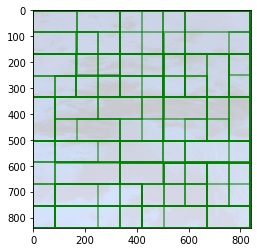

In [40]:
inp = im.numpy().transpose((1, 2, 0))/255
imshow(inp, v[100:199, :], np.ones((100, 1)))

In [56]:
v.shape

(168, 4)

In [57]:
v

array([[168,   0, 251,  83],
       [336, 588, 503, 671],
       [  0, 252, 671, 503],
       [420, 336, 503, 419],
       [168, 756, 251, 839],
       [  0,  84, 167, 335],
       [756,  84, 839, 167],
       [420, 756, 503, 839],
       [ 84, 756, 251, 839],
       [ 84, 336, 251, 419],
       [756, 252, 839, 335],
       [168, 504, 251, 587],
       [ 84, 336, 419, 503],
       [504,  84, 839, 335],
       [672, 756, 839, 839],
       [588, 336, 671, 419],
       [504,   0, 587,  83],
       [168, 336, 251, 419],
       [252, 588, 335, 671],
       [336, 252, 503, 335],
       [588, 420, 755, 503],
       [420,   0, 503,  83],
       [672, 588, 839, 755],
       [ 84, 504, 251, 587],
       [252, 336, 419, 419],
       [336,   0, 419,  83],
       [252, 420, 335, 503],
       [504, 588, 587, 671],
       [504, 588, 671, 755],
       [ 84, 672, 251, 755],
       [ 84, 672, 419, 839],
       [420, 168, 503, 251],
       [504, 336, 671, 503],
       [588, 504, 839, 755],
       [  0,  